# F. Python for Financial Data Analysis

# F.1 How to run a CAPM regression.

The CAPM postulates a linear relationship between the expected excess return of a single stock and the market-wide equity risk premium:

$$E[r_A] - r_f = \beta_A (E[r_M] - r_f).$$

Given time series observations of stock returns, the returns of a broad stock index and the riskfree rate, we can estimate the $\beta_A$ parameter via the following linear regression:

$$r_{t,A} - r_{t,f} = \alpha_A + \beta_A (r_{t,M} - r_{t,f}) + \epsilon_{t,A}.$$

The $t$ index now indicates the point of time of a certain return observation and $\alpha_A$ is added to capture any potential biases from the postulated linear relationship.

In the following, we will estimate the CAPM for the stock of Microsoft.


We start by importing the usual packages. In addition, we import the 'statsmodels' package in code line 3 to run the linear regression later on.

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

C:\Users\Adria\Programme\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
C:\Users\Adria\Programme\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


We read in the data from a csv file in code line 5 and calculate simple returns as $r_t = \frac{S_t - S_{t-1}}{S_{t-1}}$ in code lines 6 and 7. Note, in other applications, you might want to use continuously compounded returns. For now, it suffices to take any type of return and to know that you can translate one into the other.

In [2]:
data = pd.read_csv('data.csv', parse_dates = ['Date'])

data['MSFT_Ret'] = (data['Close_msft'] - data['Close_msft'].shift(1)) / data['Close_msft'].shift(1)
data['SP500_Ret'] = (data['Close_sp500'] - data['Close_sp500'].shift(1)) / data['Close_sp500'].shift(1)

We use T-Bill rates as a proxy for the riskfree rate. They are given in yearly percentage terms, so we need to scale them appropriately. We translate them from precentage figures to actual numbers by dividing the given rates by 100 and scale them to the daily horizon by dividing further by the number of trading days in a year.

In [3]:
data['Tbill_daily'] = data['Close_tbill'] / (100 * 252)
data.head()

,Date,Close_sp500,Close_tbill,Close_msft,MSFT_Ret,SP500_Ret,Tbill_daily
0,1993-11-01,469.10,3.06,2.52,NaN,NaN,0.000121
1,1993-11-02,468.44,3.12,2.50,-0.007937,-0.001407,0.000124
2,1993-11-03,463.02,3.08,2.45,-0.020000,-0.011570,0.000122
3,1993-11-04,457.49,3.07,2.38,-0.028571,-0.011943,0.000122
4,1993-11-05,459.57,3.07,2.45,0.029412,0.004547,0.000122


After the return calculation, the very first returns are NaN. This is because we do not know the price before the first price in our data sample. We drop all rows with NaN values in code line 10. This way, the NaNs will not cause problems in the further calculations.

In [4]:
data = data.dropna()
data.head()

,Date,Close_sp500,Close_tbill,Close_msft,MSFT_Ret,SP500_Ret,Tbill_daily
1,1993-11-02,468.44,3.12,2.50,-0.007937,-0.001407,0.000124
2,1993-11-03,463.02,3.08,2.45,-0.020000,-0.011570,0.000122
3,1993-11-04,457.49,3.07,2.38,-0.028571,-0.011943,0.000122
4,1993-11-05,459.57,3.07,2.45,0.029412,0.004547,0.000122
5,1993-11-08,460.21,3.06,2.45,0.000000,0.001393,0.000121


Next, we calculate excess returns for Microsoft and the S&P 500 in code lines 12 and 13.

In [5]:
data['MSFT_Ex_Ret'] = data['MSFT_Ret'] - data['Tbill_daily']
data['SP500_Ex_Ret'] = data['SP500_Ret'] - data['Tbill_daily']

We now estimate the linear CAPM relationship using OLS. Printing the result summary gives us the estimate for Microsoft's beta coefficient, which is 1.248.

In [6]:
Y = data['MSFT_Ex_Ret'].values
X = data['SP500_Ex_Ret'].values
X = sm.add_constant(X)
model = sm.OLS(Y, X)
model_fit = model.fit()
print(model_fit.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.345
Model:                            OLS   Adj. R-squared:                  0.344
Method:                 Least Squares   F-statistic:                     1241.
Date:                Fri, 22 Apr 2022   Prob (F-statistic):          7.87e-219
Time:                        19:52:00   Log-Likelihood:                 5902.4
No. Observations:                2362   AIC:                        -1.180e+04
Df Residuals:                    2360   BIC:                        -1.179e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.000      2.234      0.0

The parameter estimates of the OLS estimation can also be accessed via the 'params' attribute of the OLS result object.

In [7]:
model_fit.params

array([9.14284709e-04, 1.24797878e+00])

We end this demonstration with a graphical representation of the CAPM. The following code plots all return observations in a scatter plot and adds the estimated linear CAPM relationship.

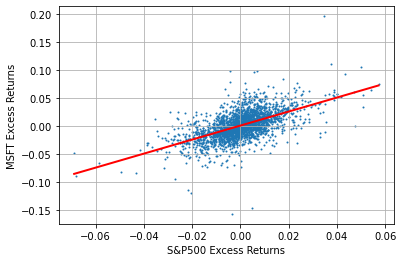

In [8]:
plt.figure(6)
plt.scatter(data['SP500_Ex_Ret'], data['MSFT_Ex_Ret'], s = 1)
x = np.linspace(data['SP500_Ex_Ret'].min(), data['SP500_Ex_Ret'].max())
plt.plot(x, model_fit.params[0] + model_fit.params[1] * x, 'r', lw=2)
plt.grid(True)
plt.axis('tight')
plt.xlabel('S&P500 Excess Returns')
plt.ylabel('MSFT Excess Returns')
plt.show()

## F.2 Fama-French 3-Factor Model

I show you how to perform a linear regression of portfolio returns on the famous Fama French 3 Factor Model.

Remember, additionally to the excess market return factor known from the CAPM, the Fama-French 3 Factor Model adds two additional factors, namely a "SMB" (small minus big) market capitalization factor and a "HML" (high minus low) book-to-market ratio factor.

The equation reads as

$$r_t - r_f = \alpha + \beta_1 \times f_t^{MER} + \beta_2 \times f_t^{SMB} + \beta_3 \times f_t^{HML} + \epsilon_t$$

We will work with daily returns of an industry portfolio (Technology) and the Fama-French factors MER, SMB and HML covering the period from summer 1926 to summer 2015.

The Fama-French factors will be extracted by an OLS linear regression, as already known from the CAPM.

In [9]:
import pandas as pd

Next, we read in the Fama-French 3 Factor data (1926-2015) from the provided csv file:

In [10]:
ff3 = pd.read_csv('ff3.csv')
ff3['Date'] = pd.to_datetime(ff3['Date'], format = '%Y%m%d')
ff3.set_index('Date', inplace=True)
ff3.head()

,MER,SMB,HML,RF
Date,,,,
1926-07-01,0.10,-0.24,-0.28,0.009
1926-07-02,0.45,-0.32,-0.08,0.009
1926-07-06,0.17,0.27,-0.35,0.009
1926-07-07,0.09,-0.59,0.03,0.009
1926-07-08,0.21,-0.36,0.15,0.009


We do the same for the daily returns of the industry portfolios, which we want to explain by our Fama french factor model:

In [11]:
indus5 = pd.read_csv('indus5.csv')
indus5['Date'] = pd.to_datetime(indus5['Date'], format = '%Y%m%d')
indus5.set_index('Date', inplace=True)
indus5.head()

,Cnsmr,Manuf,HiTec,Hlth,Other
Date,,,,,
1926-07-01,-0.08,0.22,-0.11,0.97,0.21
1926-07-02,0.46,0.69,0.31,0.13,0.11
1926-07-06,0.27,0.28,0.32,0.23,-0.19
1926-07-07,-0.01,0.11,0.12,0.33,0.15
1926-07-08,0.24,0.09,0.38,0.91,0.39


We subtract the risk-free rate to create excess returns

Finally, we can start with the regression analysis! We are going to use the statsmodels package with its Formula API, which we first need to import:

In [12]:
import statsmodels.formula.api as smf

Now we can specify how our regression formula shall look like. Remember, we want to explain the excess return of $HiTec$ by the three factors $MER$, $SMB$, $HML$. Also, we add a regression constant to capture the alpha.

As our data is organized in two dataframes, we join the two data sources on the Date column.

In [13]:
model = smf.ols('HiTec-RF ~ 1 + MER + SMB + HML', data = ff3.join(indus5))

By calling the .fit() function of the model specification, we run the OLS regression:

In [14]:
result = model.fit()

We have a look at the results:

In [15]:
print(result.summary2())

                  Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.857     
Dependent Variable: HiTec            AIC:                29099.8719
Date:               2022-04-22 19:52 BIC:                29132.1362
No. Observations:   23531            Log-Likelihood:     -14546.   
Df Model:           3                F-statistic:        4.698e+04 
Df Residuals:       23527            Prob (F-statistic): 0.00      
R-squared:          0.857            Scale:              0.20162   
--------------------------------------------------------------------
                Coef.   Std.Err.     t      P>|t|    [0.025   0.975]
--------------------------------------------------------------------
Intercept       0.0190    0.0029    6.4963  0.0000   0.0133   0.0248
MER             1.0320    0.0028  367.3346  0.0000   1.0265   1.0375
SMB            -0.0773    0.0051  -15.2175  0.0000  -0.0873  -0.0674
HML            -0.3575    0.0051  -70.2792  0.0000  -0.3675 

We can see that the FF3F factor model indeed is able to capture the variation in returns very well with an $R^2 = 0.857$! Also, all of our three factors have significant loadings as the t-values are greater than 3.

Our portfolio was overperforming compared to the market with a significant alpha of $1.9\%$ per year!